In [73]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

def load_pro_mat_to_dataframe(file_path):
    """
    Load downsampled fields from a MATLAB v7.3 _pro.mat file into a pandas DataFrame.

    Parameters:
        file_path (str): Path to the _pro.mat file.

    Returns:
        pd.DataFrame: A DataFrame containing the downsampled fields.
    """
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Navigate to the 'exptData' group
        if 'exptData' not in f:
            raise ValueError(f"The file {file_path} does not contain 'exptData'.")
        
        expt_data = f['exptData']
        
        # List of fields to extract
        fields_to_include = [
            'tDS', 'optoStim', 'g4displayXPos','headingPosition', 'angularVelocity',
            'angularSpeed', 'forwardPosition', 'forwardVelocity',
            'sidewaysPosition', 'sidewaysVelocity', 'totSpeed', 'x', 'y'
        ]
        
        # Extract and flatten the fields
        data_dict = {}
        for field in fields_to_include:
            if field in expt_data:
                data_dict[field] = expt_data[field][()].flatten()
            else:
                raise KeyError(f"Field '{field}' is missing in 'exptData'.")
        data_dict['angularSpeed_radian'] = np.radians(data_dict['angularSpeed'])
    # Create DataFrame
    df = pd.DataFrame(data_dict)
    return df

# Example usage:
# file_path = 'path/to/your/_pro.mat'
# df = load_pro_mat_to_dataframe(file_path)
# print(df)

def load_all_pro_mat_files_to_df(directory_path):
    """
    Loop through all _pro.mat files in a directory and create a combined DataFrame.

    Parameters:
        directory_path (str): Path to the directory containing _pro.mat files.

    Returns:
        pd.DataFrame: A combined DataFrame with data from all files, including columns for file names, file IDs, and fly IDs.
    """
    combined_df = pd.DataFrame()
    fileid = 0  # Initialize file ID
    flyid = 0  # Initialize fly ID
    unique_fly_combinations = {}  # Dictionary to track unique combinations of date and fly number

    # Loop through all .mat files in the directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('_pro.mat'):
            file_path = os.path.join(directory_path, file_name)
            print(f"Loading file: {file_path}")

            try:
                # Load the .mat file into a DataFrame
                df = load_pro_mat_to_dataframe(file_path)
                # update by adding theta_g and rho_t
                df = calculate_theta_g_rho(df)

                # Add a column for the file name
                df['fileName'] = file_name

                # Add a column for the file ID
                df['fileid'] = fileid
                df['modal_heading'] = circular_mode(df['g4displayXPos'])
                df['avg_rho_t'] = df['rho_t'].mean()

                # Extract the date and fly number from the file name
                # Assumes the file name contains "_YYYY_MM_DD_flyXX_"
                match = re.search(r'_(\d{4}_\d{2}_\d{2})_fly(\d+)_', file_name)
                if match:
                    date = match.group(1)  # Extracted date
                    fly_number = int(match.group(2))  # Extracted fly number
                    combination = (date, fly_number)

                    # Check if the combination is unique
                    if combination not in unique_fly_combinations:
                        unique_fly_combinations[combination] = flyid
                        flyid += 1

                    # Assign the corresponding flyid
                    df['flyid'] = unique_fly_combinations[combination]
                else:
                    df['flyid'] = None  # Assign None if date or fly number is not found

                # Append the DataFrame to the combined DataFrame
                combined_df = pd.concat([combined_df, df], ignore_index=True)

                # Increment the file ID
                fileid += 1
            except Exception as e:
                print(f"Error loading file {file_name}: {e}")

    return combined_df


def smooth_time_series(df, column, window_size, method='moving_average'):
    """
    Smooth a time series in a Pandas DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the time series.
        column (str): The column name of the time series to be smoothed.
        window_size (int): The size of the smoothing window.
        method (str): The smoothing method ('moving_average' or 'gaussian').

    Returns:
        pd.Series: A smoothed version of the time series.
    """
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found in DataFrame.")
    
    if method == 'moving_average':
        # Moving average smoothing
        smoothed_series = df[column].rolling(window=window_size, center=True).mean()
    elif method == 'gaussian':
        # Gaussian smoothing
        smoothed_series = df[column].rolling(window=window_size, win_type='gaussian', center=True).mean(std=window_size / 2)
    else:
        raise ValueError("Method must be 'moving_average' or 'gaussian'.")
    
    return smoothed_series



def calculate_theta_g_rho(df, window_size=5000, speed_threshold=1):
    """
    Calculate the goal direction (theta_g) and consistency of head direction (rho_t) for each time point.
    
    Parameters:
    - df: DataFrame containing 'forward', 'side', 'yaw', and 'heading' columns (time series of a trial).
    - window_size: The size of the window in seconds to compute the rolling statistics.
    - speed_threshold: Speed threshold below which the fly is considered standing still.
    
    Returns:
    - A DataFrame with 'theta_g' and 'rho_t' columns added (same length as input).
    """
    # Ensure 'totSpeed' and 'g4displayXPos' are valid
    if 'totSpeed' not in df.columns or 'g4displayXPos' not in df.columns:
        raise ValueError("The DataFrame must contain 'totSpeed' and 'g4displayXPos' columns.")
    
    # Compute the rolling sums for sin and cos of g4displayXPos
    df['sin_head'] = np.sin(df['g4displayXPos'])
    df['cos_head'] = np.cos(df['g4displayXPos'])

    # Apply rolling sum only for valid rows where totSpeed > speed_threshold
    valid_rows = df['totSpeed'] > speed_threshold
    rolling_sin_sum = df.loc[valid_rows, 'sin_head'].rolling(window_size, center=True, min_periods=1).sum()
    rolling_cos_sum = df.loc[valid_rows, 'cos_head'].rolling(window_size, center=True, min_periods=1).sum()
    rolling_count = df.loc[valid_rows, 'sin_head'].rolling(window_size, center=True, min_periods=1).count()

    # Compute theta_g (goal direction) and rho_t (consistency)
    theta_g = np.arctan2(rolling_sin_sum, rolling_cos_sum) % (2 * np.pi)
    rho_t = np.sqrt((rolling_cos_sum / rolling_count) ** 2 + (rolling_sin_sum / rolling_count) ** 2)

    # Assign calculated values back to the DataFrame
    df['theta_g'] = np.nan
    df['rho_t'] = np.nan
    df.loc[valid_rows, 'theta_g'] = theta_g
    df.loc[valid_rows, 'rho_t'] = rho_t

    # Drop temporary columns used for calculations
    df.drop(columns=['sin_head', 'cos_head'], inplace=True)
    
    return df


def circular_mode(data, bins=360):
    """Calculate the circular mode of the given data."""
    #data_rad = np.deg2rad(data)
    density = gaussian_kde(data)
    x = np.linspace(0, 2*np.pi, bins)
    y = density(x)
    peaks, _ = find_peaks(y)
    mode_idx = peaks[np.argmax(y[peaks])]
    return x[mode_idx]


def plot_opto_window_overlay(df, forward_velocity_col='forwardVelocity', angular_speed_col='angularSpeed_radian', opto_col='optoStim', time_col='tDS', window=(-2, 3)):
    """
    Overlay forward velocity and angular speed traces around multiple opto-stim onset windows.
    Also plots the average trace with a thicker line.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        angular_speed_col (str): Column name for angular speed.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in df.columns or time_col not in df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    # Detect opto-stim onset times (transition from <0.1 to >0.1)
    opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
    opto_on_times = df.loc[opto_onset_indices, time_col].values

    if len(opto_on_times) == 0:
        raise ValueError("No opto-stim 'onset' events found in the data.")

    aligned_traces = {'time': [], 'forward_velocity': [], 'angular_speed': []}

    # Loop through each opto-stim onset time and extract the surrounding window
    for opto_time in opto_on_times:
        df['aligned_time'] = df[time_col] - opto_time
        window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
        window_df = df[window_mask]

        if not window_df.empty:
            aligned_traces['time'].append(window_df['aligned_time'].values)
            aligned_traces['forward_velocity'].append(window_df[forward_velocity_col].values)
            aligned_traces['angular_speed'].append(window_df[angular_speed_col].values)

    # Convert aligned traces to arrays for averaging
    forward_velocity_array = np.array(aligned_traces['forward_velocity'])
    angular_speed_array = np.array(aligned_traces['angular_speed'])

    # Calculate the average trace
    avg_forward_velocity = np.nanmean(forward_velocity_array, axis=0)
    avg_angular_speed = np.nanmean(angular_speed_array, axis=0)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot forward velocity
    for trace in aligned_traces['forward_velocity']:
        ax[0].plot(aligned_traces['time'][0], trace, color='blue',alpha=0.3)
    ax[0].plot(aligned_traces['time'][0], avg_forward_velocity, color='blue', linewidth=2, label='Average Trace')
    ax[0].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].set_ylabel('Forward Velocity (units)')
    ax[0].set_title('Forward Velocity Around Opto-Stim Onset')
    ax[0].legend()

    # Plot angular speed
    for trace in aligned_traces['angular_speed']:
        ax[1].plot(aligned_traces['time'][0], trace, color='green', alpha=0.3)
    ax[1].plot(aligned_traces['time'][0], avg_angular_speed, color='green', linewidth=2, label='Average Trace')
    ax[1].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular Speed (units)')
    ax[1].set_title('Angular Speed Around Opto-Stim Onset')
    ax[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


def plot_opto_window_overlay_combined_flyavg(
    combined_df, 
    forward_velocity_col='forwardVelocity', 
    angular_speed_col='angularSpeed_radian', 
    opto_col='optoStim', 
    time_col='tDS', 
    file_id_col='fileid', 
    fly_id_col='flyid', 
    window=(-2, 3)
):
    """
    Overlay forward velocity and angular speed traces around multiple opto-stim onset windows for each fileID.
    Also plots the average trace for each fly and the overall average trace with thicker lines.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        angular_speed_col (str): Column name for angular speed.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()
    fly_avg_data = {}

    all_forward_velocity = []
    all_angular_speed = []
    all_times = []

    # Plotting setup
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'forward_velocity': [], 'angular_speed': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time
            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['forward_velocity'].append(window_df[forward_velocity_col].values)
                aligned_traces['angular_speed'].append(window_df[angular_speed_col].values)

        # Collect traces for averaging
        forward_velocity_array = np.array(aligned_traces['forward_velocity'])
        angular_speed_array = np.array(aligned_traces['angular_speed'])

        if forward_velocity_array.size > 0 and angular_speed_array.size > 0:
            avg_forward_velocity_file = np.nanmean(forward_velocity_array, axis=0)
            avg_angular_speed_file = np.nanmean(angular_speed_array, axis=0)

            # Accumulate averages by flyid
            fly_id = df[fly_id_col].iloc[0]
            if fly_id not in fly_avg_data:
                fly_avg_data[fly_id] = {'forward_velocity': [], 'angular_speed': [], 'time': []}

            fly_avg_data[fly_id]['forward_velocity'].append(avg_forward_velocity_file)
            fly_avg_data[fly_id]['angular_speed'].append(avg_angular_speed_file)
            fly_avg_data[fly_id]['time'].append(aligned_traces['time'][0])

            # Plot individual traces for this file
            for trace in aligned_traces['forward_velocity']:
                ax[0].plot(aligned_traces['time'][0], trace, color='blue', alpha=0.05)
            for trace in aligned_traces['angular_speed']:
                ax[1].plot(aligned_traces['time'][0], trace, color='green', alpha=0.05)

    # Plot averages by flyid
    for fly_id, fly_data in fly_avg_data.items():
        avg_forward_velocity_fly = np.nanmean(fly_data['forward_velocity'], axis=0)
        avg_angular_speed_fly = np.nanmean(fly_data['angular_speed'], axis=0)

        # Plot average traces for this fly
        ax[0].plot(fly_data['time'][0], avg_forward_velocity_fly, linewidth=1.5, color='blue', alpha=0.5, label=f'Fly {fly_id}')
        ax[1].plot(fly_data['time'][0], avg_angular_speed_fly, linewidth=1.5, color='green', alpha=0.5, label=f'Fly {fly_id}')

        # Append for overall averages
        all_forward_velocity.extend(fly_data['forward_velocity'])
        all_angular_speed.extend(fly_data['angular_speed'])
        all_times.extend(fly_data['time'])

    # Calculate overall averages
    forward_velocity_array = np.array(all_forward_velocity)
    angular_speed_array = np.array(all_angular_speed)
    avg_forward_velocity = np.nanmean(forward_velocity_array, axis=0)
    avg_angular_speed = np.nanmean(angular_speed_array, axis=0)

    # Plot overall average traces
    ax[0].plot(fly_data['time'][0], avg_forward_velocity, color='blue', linewidth=3, label='Overall Avg')
    ax[1].plot(fly_data['time'][0], avg_angular_speed, color='green', linewidth=3, label='Overall Avg')

    # Finalize plots
    ax[0].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].set_ylabel('Forward Velocity (units)')
    ax[0].set_title('Forward Velocity Around Opto-Stim Onset')
    ax[0].legend()

    ax[1].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular Speed (units)')
    ax[1].set_ylim([0, 10])
    ax[1].set_title('Angular Speed Around Opto-Stim Onset')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


def plot_opto_window_overlay_combined(
    combined_df, 
    forward_velocity_col='forwardVelocity', 
    angular_speed_col='angularSpeed_radian', 
    opto_col='optoStim', 
    time_col='tDS', 
    file_id_col='fileid', 
    fly_id_col='flyid', 
    window=(-2, 3), 
    threshold_forward_velocity=1.0, 
    threshold_angular_speed=0.5
):
    """
    Overlay forward velocity and angular speed traces around multiple opto-stim onset windows for each fileID.
    Also plots the average trace for each fly and the overall average trace with thicker lines.
    Optionally highlights traces where the pre-stimulus period velocity and speed are below thresholds.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        angular_speed_col (str): Column name for angular speed.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        window (tuple): Time window around opto-stim onset in seconds (start, end).
        threshold_forward_velocity (float): Threshold for average pre-stimulus forward velocity.
        threshold_angular_speed (float): Threshold for average pre-stimulus angular speed.

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()
    fly_avg_data = {}

    all_forward_velocity_ok = []
    all_angular_speed_ok = []
    all_forward_velocity_not_ok = []
    all_angular_speed_not_ok = []
    all_times = []

    # Plotting setup
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'forward_velocity': [], 'angular_speed': [], 'pre_stim_ok': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time
            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            pre_stim_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] < 0)
            window_df = df[window_mask]

            if not window_df.empty:
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['forward_velocity'].append(window_df[forward_velocity_col].values)
                aligned_traces['angular_speed'].append(window_df[angular_speed_col].values)

                # Check pre-stimulus thresholds using the average
                pre_stim_df = df[pre_stim_mask]
                pre_stim_ok = (
                    pre_stim_df[forward_velocity_col].abs().mean() < threshold_forward_velocity and
                    pre_stim_df[angular_speed_col].abs().mean() < threshold_angular_speed
                )
                aligned_traces['pre_stim_ok'].append(pre_stim_ok)

        # Collect traces for averaging
        forward_velocity_array = np.array(aligned_traces['forward_velocity'])
        angular_speed_array = np.array(aligned_traces['angular_speed'])

        if forward_velocity_array.size > 0 and angular_speed_array.size > 0:
            # Separate traces based on pre-stimulus check
            for trace, pre_stim_ok in zip(forward_velocity_array, aligned_traces['pre_stim_ok']):
                if pre_stim_ok:
                    all_forward_velocity_ok.append(trace)
                else:
                    all_forward_velocity_not_ok.append(trace)
            for trace, pre_stim_ok in zip(angular_speed_array, aligned_traces['pre_stim_ok']):
                if pre_stim_ok:
                    all_angular_speed_ok.append(trace)
                else:
                    all_angular_speed_not_ok.append(trace)

            # Plot individual traces
            for trace, pre_stim_ok in zip(aligned_traces['forward_velocity'], aligned_traces['pre_stim_ok']):
                color = 'red' if pre_stim_ok else 'blue'
                #alpha = 0.2 if pre_stim_ok else 0.05
                ax[0].plot(aligned_traces['time'][0], trace, color=color, alpha=0.1)
            for trace, pre_stim_ok in zip(aligned_traces['angular_speed'], aligned_traces['pre_stim_ok']):
                color = 'orange' if pre_stim_ok else 'green'
                #alpha = 0.2 if pre_stim_ok else 0.05
                ax[1].plot(aligned_traces['time'][0], trace, color=color, alpha=0.1)
    
    # Calculate overall averages for pre-stim OK and not OK
    avg_forward_velocity_ok = np.nanmean(np.array(all_forward_velocity_ok), axis=0) if all_forward_velocity_ok else None
    avg_forward_velocity_not_ok = np.nanmean(np.array(all_forward_velocity_not_ok), axis=0) if all_forward_velocity_not_ok else None
    avg_angular_speed_ok = np.nanmean(np.array(all_angular_speed_ok), axis=0) if all_angular_speed_ok else None
    avg_angular_speed_not_ok = np.nanmean(np.array(all_angular_speed_not_ok), axis=0) if all_angular_speed_not_ok else None

    # Plot overall averages
    if avg_forward_velocity_ok is not None:
        ax[0].plot(aligned_traces['time'][0], avg_forward_velocity_ok, color='purple', linewidth=3, label='Overall Avg (Pre-Stim Not OK)')
    if avg_forward_velocity_not_ok is not None:
        ax[0].plot(aligned_traces['time'][0], avg_forward_velocity_not_ok, color='blue', linewidth=3, label='Overall Avg (Pre-Stim OK)')

    if avg_angular_speed_ok is not None:
        ax[1].plot(aligned_traces['time'][0], avg_angular_speed_ok, color='orange', linewidth=3, label='Overall Avg (Pre-Stim Not OK)')
    if avg_angular_speed_not_ok is not None:
        ax[1].plot(aligned_traces['time'][0], avg_angular_speed_not_ok, color='green', linewidth=3, label='Overall Avg (Pre-Stim OK)')

    # Finalize plots
    ax[0].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].set_ylabel('Forward Velocity (units)')
    ax[0].set_title('Forward Velocity Around Opto-Stim Onset')
    ax[0].legend()

    ax[1].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular Speed (units)')
    ax[1].set_ylim([0, 10])
    ax[1].set_title('Angular Speed Around Opto-Stim Onset')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


# Function to calculate circular difference
def circular_difference(angle1, angle2):
    return np.abs(np.angle(np.exp(1j * (angle1 - angle2))))

def plot_opto_window_overlay_heading_0(
    combined_df,
    g4display_col='g4displayXPos',
    modal_heading_col='modal_heading',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    avg_rho_col='avg_rho_t',
    forward_velocity_col='forwardVelocity',
    threshold_forward_velocity=2.0,
    window=(-2, 3)
):
    """
    Overlay traces of the circular difference between `g4displayXPos` and `modal_heading`
    around multiple opto-stim onset windows for each fileID, colored by `avg_rho_t`.
    Trials where the fly stopped during the pre-stim window are excluded.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        g4display_col (str): Column name for the `g4displayXPos`.
        modal_heading_col (str): Column name for the `modal_heading`.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        avg_rho_col (str): Column name for the average rho value.
        forward_velocity_col (str): Column name for forward velocity.
        threshold_forward_velocity (float): Threshold for mean forward velocity to include trials.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    # Plotting setup
    fig, ax = plt.subplots(figsize=(10, 6))

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'circular_diff': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time

            # Pre-stimulus window mask
            prestim_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] < 0)
            prestim_df = df[prestim_mask]

            # Exclude trials where the mean forward velocity in pre-stim window is below the threshold
            if prestim_df[forward_velocity_col].mean() < threshold_forward_velocity:
                continue

            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                circular_diff = circular_difference(window_df[g4display_col].values, window_df[modal_heading_col].values)
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['circular_diff'].append(circular_diff)

        # Get color for this file based on avg_rho_t
        avg_rho = df[avg_rho_col].iloc[0] if avg_rho_col in df.columns else 0.5
        color = plt.cm.viridis(avg_rho)

        # Plot individual traces for this file
        for trace in aligned_traces['circular_diff']:
            ax.scatter(aligned_traces['time'][0], trace, color=color, alpha=0.6, s=1)

    # Finalize plots
    ax.axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Circular Difference (radians)')
    ax.set_title('Circular Difference Around Opto-Stim Onset')

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Avg Rho (Normalized)')

    plt.tight_layout()
    plt.show()

def plot_opto_window_overlay_heading_1(
    combined_df,
    g4display_col='g4displayXPos',
    modal_heading_col='modal_heading',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    avg_rho_col='avg_rho_t',
    circular_variance_threshold=0.05,
    window=(-2, 3),
    n_bins=5
):
    """
    Overlay traces of the circular difference between `g4displayXPos` and `modal_heading`
    around multiple opto-stim onset windows for each fileID, colored by `avg_rho_t`.
    Trials with circular variance of `g4displayXPos` below a threshold in the plotting window are excluded.
    Additionally, plots averages for n bins dividing 0 to pi (range of absolute circular difference at t=0).
    Separates the averages for each bin by a threshold on `avg_rho_t`.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        g4display_col (str): Column name for the `g4displayXPos`.
        modal_heading_col (str): Column name for the `modal_heading`.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        avg_rho_col (str): Column name for the average rho value.
        circular_variance_threshold (float): Threshold for circular variance to include trials.
        window (tuple): Time window around opto-stim onset in seconds (start, end).
        n_bins (int): Number of bins for dividing absolute circular difference at t=0.

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    # Initialize bins for averages
    bin_edges = np.linspace(0, np.pi, n_bins + 1)
    binned_traces_high = {i: [] for i in range(n_bins)}
    binned_traces_low = {i: [] for i in range(n_bins)}
    time_vector = None

    # Plotting setup
    fig, ax = plt.subplots(figsize=(12, 8))

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'circular_diff': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time

            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                # Calculate circular variance for the plotting window
                circ_variance = circular_variance(window_df[g4display_col].values)

                # Exclude trials with circular variance below the threshold
                if circ_variance < circular_variance_threshold:
                    continue

                circular_diff = circular_difference(window_df[g4display_col].values, window_df[modal_heading_col].values)
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['circular_diff'].append(circular_diff)

                # Bin traces based on absolute circular difference at t=0
                zero_point_idx = np.argmin(np.abs(window_df['aligned_time'].values))
                abs_circ_diff_at_zero = np.abs(circular_diff[zero_point_idx])
                for i in range(n_bins):
                    if bin_edges[i] <= abs_circ_diff_at_zero < bin_edges[i + 1]:
                        avg_rho = df[avg_rho_col].iloc[0] if avg_rho_col in df.columns else 0.5
                        if avg_rho > 0.65:
                            binned_traces_high[i].append(circular_diff)
                        else:
                            binned_traces_low[i].append(circular_diff)
                        break

        # Get color for this file based on avg_rho_t
        avg_rho = df[avg_rho_col].iloc[0] if avg_rho_col in df.columns else 0.5
        color = plt.cm.viridis(avg_rho)

        # Plot individual traces for this file
        for trace in aligned_traces['circular_diff']:
            ax.scatter(aligned_traces['time'][0], trace, color=color, alpha=0.6, s=1)

        # Set time vector for binned averages
        if time_vector is None and len(aligned_traces['time']) > 0:
            time_vector = aligned_traces['time'][0]

    # Plot binned averages, separated by avg_rho threshold
    for i in range(n_bins):
        if binned_traces_high[i]:
            avg_trace_high = np.nanmean(binned_traces_high[i], axis=0)
            ax.plot(time_vector, avg_trace_high, linewidth=2, label=f'High Rho Bin {i + 1}: {bin_edges[i]:.2f}-{bin_edges[i + 1]:.2f}', color='blue')
        if binned_traces_low[i]:
            avg_trace_low = np.nanmean(binned_traces_low[i], axis=0)
            ax.plot(time_vector, avg_trace_low, linewidth=2, label=f'Low Rho Bin {i + 1}: {bin_edges[i]:.2f}-{bin_edges[i + 1]:.2f}', color='red')

    # Finalize plots
    ax.axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Circular Difference (radians)')
    ax.set_title('Circular Difference Around Opto-Stim Onset (Binned by Circular Difference at t=0)')
    ax.legend()

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Avg Rho (Normalized)')

    plt.tight_layout()
    plt.show()


def plot_opto_window_overlay_heading_2(
    combined_df,
    g4display_col='g4displayXPos',
    modal_heading_col='modal_heading',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    avg_rho_col='avg_rho_t',
    forward_velocity_col='forwardVelocity',
    threshold_forward_velocity=1.0,
    window=(-2, 3)
):
    """
    Overlay traces of the circular difference between `g4displayXPos` and `modal_heading`
    around multiple opto-stim onset windows for each fileID, colored by `avg_rho_t`.
    Trials where the fly stopped during the pre-stim window are excluded.
    All traces are zeroed at the opto onset (midpoint of the plotting window).

    Additionally, plots the global average trace for traces with avg_rho_t above and below 0.8.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        g4display_col (str): Column name for the `g4displayXPos`.
        modal_heading_col (str): Column name for the `modal_heading`.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        avg_rho_col (str): Column name for the average rho value.
        forward_velocity_col (str): Column name for forward velocity.
        threshold_forward_velocity (float): Threshold for mean forward velocity to include trials.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    high_rho_traces = []
    low_rho_traces = []
    time_vector = None

    # Plotting setup
    fig, ax = plt.subplots(figsize=(10, 6))

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'circular_diff': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time

            # Pre-stimulus window mask
            prestim_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] < 0)
            prestim_df = df[prestim_mask]

            # Exclude trials where the mean forward velocity in pre-stim window is below the threshold
            if prestim_df[forward_velocity_col].mean() < threshold_forward_velocity:
                continue

            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                circular_diff = circular_difference(window_df[g4display_col].values, window_df[modal_heading_col].values)
                # Zero out traces at opto onset (midpoint of the plotting window)
                zero_point_idx = np.argmin(np.abs(window_df['aligned_time'].values))
                circular_diff -= circular_diff[zero_point_idx]
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['circular_diff'].append(circular_diff)

        # Get color for this file based on avg_rho_t
        avg_rho = df[avg_rho_col].iloc[0] if avg_rho_col in df.columns else 0.5
        color = plt.cm.viridis(avg_rho)

        # Plot individual traces for this file
        for trace in aligned_traces['circular_diff']:
            ax.scatter(aligned_traces['time'][0], trace, color=color, alpha=0.5, s=1)

        # Separate traces into high and low avg_rho groups
        if avg_rho > 0.8:
            high_rho_traces.extend(aligned_traces['circular_diff'])
        else:
            low_rho_traces.extend(aligned_traces['circular_diff'])

        # Set time vector for global averages
        if time_vector is None and len(aligned_traces['time']) > 0:
            time_vector = aligned_traces['time'][0]

    # Compute and plot global averages for high and low avg_rho groups
    if high_rho_traces:
        high_rho_avg = np.nanmean(high_rho_traces, axis=0)
        ax.plot(time_vector, high_rho_avg, color='blue', linewidth=2, label='High Avg Rho (>0.8)')

    if low_rho_traces:
        low_rho_avg = np.nanmean(low_rho_traces, axis=0)
        ax.plot(time_vector, low_rho_avg, color='red', linewidth=2, label='Low Avg Rho (<=0.8)')

    # Finalize plots
    ax.axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Circular Difference (radians)')
    ax.set_title('Circular Difference Around Opto-Stim Onset')
    ax.legend()

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Avg Rho (Normalized)')

    plt.tight_layout()
    plt.show()

def circular_variance(angles):
    """Calculate circular variance of angles."""
    return 1 - np.abs(np.mean(np.exp(1j * angles)))

def plot_opto_window_overlay_heading_3(
    combined_df,
    g4display_col='g4displayXPos',
    modal_heading_col='modal_heading',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    avg_rho_col='avg_rho_t',
    rho_threshold=0.8,
    circular_variance_threshold=0.05,
    window=(-2, 3)
):
    """
    Overlay traces of the circular difference between `g4displayXPos` and `modal_heading`
    around multiple opto-stim onset windows for each fileID, colored by `avg_rho_t`.
    Trials with circular variance of `g4displayXPos` below a threshold in the plotting window are excluded.
    All traces are zeroed at the opto onset (midpoint of the plotting window).

    Additionally, plots the global average trace for traces with avg_rho_t above and below 0.8.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        g4display_col (str): Column name for the `g4displayXPos`.
        modal_heading_col (str): Column name for the `modal_heading`.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        avg_rho_col (str): Column name for the average rho value.
        circular_variance_threshold (float): Threshold for circular variance to include trials.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    high_rho_traces = []
    low_rho_traces = []
    time_vector = None

    # Plotting setup
    fig, ax = plt.subplots(figsize=(10, 6))

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'circular_diff': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time

            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                # Calculate circular variance for the plotting window
                circ_variance = circular_variance(window_df[g4display_col].values)

                # Exclude trials with circular variance below the threshold
                if circ_variance < circular_variance_threshold:
                    continue

                circular_diff = circular_difference(window_df[g4display_col].values, window_df[modal_heading_col].values)
                # Zero out traces at opto onset (midpoint of the plotting window)
                zero_point_idx = np.argmin(np.abs(window_df['aligned_time'].values))
                circular_diff -= circular_diff[zero_point_idx]
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['circular_diff'].append(circular_diff)

        # Get color for this file based on avg_rho_t
        avg_rho = df[avg_rho_col].iloc[0] if avg_rho_col in df.columns else 0.5
        color = plt.cm.viridis(avg_rho)

        # Plot individual traces for this file
        for trace in aligned_traces['circular_diff']:
            ax.plot(aligned_traces['time'][0], trace, color=color, alpha=0.8)

        # Separate traces into high and low avg_rho groups
        if avg_rho > rho_threshold:
            high_rho_traces.extend(aligned_traces['circular_diff'])
        else:
            low_rho_traces.extend(aligned_traces['circular_diff'])

        # Set time vector for global averages
        if time_vector is None and len(aligned_traces['time']) > 0:
            time_vector = aligned_traces['time'][0]

    # Compute and plot global averages for high and low avg_rho groups
    if high_rho_traces:
        high_rho_avg = np.nanmean(high_rho_traces, axis=0)
        ax.plot(time_vector, high_rho_avg, color='blue', linewidth=2, label=f'High Avg Rho (>{rho_threshold}')

    if low_rho_traces:
        low_rho_avg = np.nanmean(low_rho_traces, axis=0)
        ax.plot(time_vector, low_rho_avg, color='red', linewidth=2, label=f'Low Avg Rho (<={rho_threshold}')

    # Finalize plots
    ax.axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Circular Difference (radians)')
    ax.set_title('Circular Difference Around Opto-Stim Onset')
    ax.legend()

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Avg Rho (Normalized)')

    plt.tight_layout()
    plt.show()



In [2]:
# Example usage:
file_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/_2024_12_06_fly01_session01_trial01B pattern20 stim2 ftmode0_pro.mat'
df = load_pro_mat_to_dataframe(file_path)
df

tDS  optoStim  g4displayXPos  headingPosition  angularVelocity  \
0         0.0000       0.0       6.150311        10.167017       -15.725880   
1         0.0015       0.0       6.150918        10.143315       -15.783733   
2         0.0030       0.0       6.151526        10.119364       -15.837127   
3         0.0045       0.0       6.150716        10.095173       -15.885580   
4         0.0060       0.0       6.150716        10.070752       -15.928585   
...          ...       ...            ...              ...              ...   
266662  399.9930       0.0       5.692596       127.549205        18.834528   
266663  399.9945       0.0       5.693001       127.575903        18.474794   
266664  399.9960       0.0       5.692798       127.601844        18.118488   
266665  399.9975       0.0       5.692596       127.627028        17.765929   
266666  399.9990       0.0       5.693001       127.651457        17.417389   

        angularSpeed  forwardPosition  forwardVelocity  sidewaysPosition  \
0          15.725880         0.001947        -0.186355         -0.005570   
1          15.783733         0.001631        -0.180952         -0.006781   
2          15.837127         0.001325        -0.175379         -0.007991   
3          15.885580         0.001027        -0.169634         -0.009200   
4          15.928585         0.000739        -0.163712         -0.010407   
...              ...              ...              ...               ...   
266662     18.834528       767.189817         1.393224       -336.858621   
266663     18.474794       767.191749         1.361897       -336.859047   
266664     18.118488       767.193619         1.331057       -336.859426   
266665     17.765929       767.195427         1.300716       -336.859759   
266666     17.417389       767.197175         1.270883       -336.860051   

        sidewaysVelocity  totSpeed           x           y  \
0              -0.785928  2.207391    0.000000    0.000000   
1              -0.783202  2.203805   -0.001175   -0.000272   
2              -0.780234  2.199459   -0.002345   -0.000536   
3              -0.777013  2.194297   -0.003510   -0.000792   
4              -0.773524  2.188264   -0.004670   -0.001039   
...                  ...       ...         ...         ...   
266662         -0.515737  3.388222  336.665258  396.155649   
266663         -0.477407  3.290311  336.667402  396.155344   
266664         -0.440757  3.194837  336.669478  396.155011   
266665         -0.405729  3.101778  336.671490  396.154651   
266666         -0.372262  3.011104  336.673439  396.154267   

        angularSpeed_radian  
0                  0.274468  
1                  0.275478  
2                  0.276410  
3                  0.277256  
4                  0.278006  
...                     ...  
266662             0.328725  
266663             0.322446  
266664             0.316227  
266665             0.310074  
266666             0.303991  

[266667 rows x 14 columns]

In [3]:
df_rho = calculate_theta_g_rho(df, window_size=5000, speed_threshold=1)

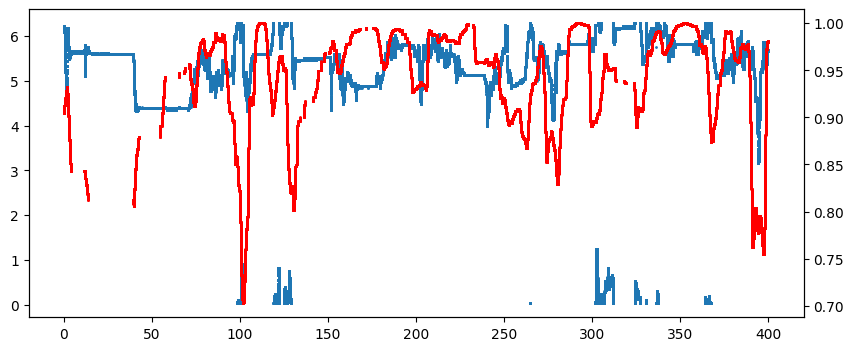

In [7]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(df_rho.tDS, df_rho.g4displayXPos,s=1)
ax2 = ax.twinx()
ax2.scatter(df_rho.tDS, df_rho.rho_t,s=1,c='red')
#ax.scatter(df_rho.tDS, df_rho.theta_g,s=1,c='green')

In [10]:
folder_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09'
combined_df_MBON09 = load_all_pro_mat_files_to_df(folder_path)

Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09\_2024_12_06_fly01_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09\_2024_12_06_fly01_session01_trial02B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09\_2024_12_06_fly02_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09\_2024_12_06_fly03_session01_trial01A pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09\_2024_12_06_fly03_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/

In [11]:
combined_df_MBON09

tDS  optoStim  g4displayXPos  headingPosition  angularVelocity  \
0          0.0000       0.0       6.150311        10.167017       -15.725880   
1          0.0015       0.0       6.150918        10.143315       -15.783733   
2          0.0030       0.0       6.151526        10.119364       -15.837127   
3          0.0045       0.0       6.150716        10.095173       -15.885580   
4          0.0060       0.0       6.150716        10.070752       -15.928585   
...           ...       ...            ...              ...              ...   
9600007  399.9930       0.0       0.784713     15473.231562        -1.329036   
9600008  399.9945       0.0       0.784915     15473.229512        -1.319219   
9600009  399.9960       0.0       0.785118     15473.227501        -1.308738   
9600010  399.9975       0.0       0.785522     15473.225530        -1.297656   
9600011  399.9990       0.0       0.784915     15473.223602        -1.286038   

         angularSpeed  forwardPosition  forwardVelocity  sidewaysPosition  \
0           15.725880         0.001947        -0.186355         -0.005570   
1           15.783733         0.001631        -0.180952         -0.006781   
2           15.837127         0.001325        -0.175379         -0.007991   
3           15.885580         0.001027        -0.169634         -0.009200   
4           15.928585         0.000739        -0.163712         -0.010407   
...               ...              ...              ...               ...   
9600007      1.329036      3228.524763        -0.020714        -55.220858   
9600008      1.319219      3228.524725        -0.021504        -55.220858   
9600009      1.308738      3228.524685        -0.022262        -55.220857   
9600010      1.297656      3228.524644        -0.022989        -55.220856   
9600011      1.286038      3228.524602        -0.023684        -55.220856   

         sidewaysVelocity  ...           x          y  angularSpeed_radian  \
0               -0.785928  ...    0.000000   0.000000             0.274468   
1               -0.783202  ...   -0.001175  -0.000272             0.275478   
2               -0.780234  ...   -0.002345  -0.000536             0.276410   
3               -0.777013  ...   -0.003510  -0.000792             0.277256   
4               -0.773524  ...   -0.004670  -0.001039             0.278006   
...                   ...  ...         ...        ...                  ...   
9600007          0.000787  ...  203.307878 -20.065339             0.023196   
9600008          0.000733  ...  203.307850 -20.065356             0.023025   
9600009          0.000683  ...  203.307822 -20.065373             0.022842   
9600010          0.000636  ...  203.307792 -20.065390             0.022648   
9600011          0.000592  ...  203.307761 -20.065408             0.022446   

          theta_g     rho_t  \
0        5.586334  0.904629   
1        5.586367  0.904666   
2        5.586399  0.904703   
3        5.586432  0.904740   
4        5.586464  0.904777   
...           ...       ...   
9600007       NaN       NaN   
9600008       NaN       NaN   
9600009       NaN       NaN   
9600010       NaN       NaN   
9600011       NaN       NaN   

                                                  fileName fileid  \
0        _2024_12_06_fly01_session01_trial01B pattern20...      0   
1        _2024_12_06_fly01_session01_trial01B pattern20...      0   
2        _2024_12_06_fly01_session01_trial01B pattern20...      0   
3        _2024_12_06_fly01_session01_trial01B pattern20...      0   
4        _2024_12_06_fly01_session01_trial01B pattern20...      0   
...                                                    ...    ...   
9600007  _2025_01_04_fly10_session01_trial02C pattern20...     35   
9600008  _2025_01_04_fly10_session01_trial02C pattern20...     35   
9600009  _2025_01_04_fly10_session01_trial02C pattern20...     35   
9600010  _2025_01_04_fly10_session01_trial02C pattern20...     35   
9600011  _2025_01_04_fly10_session01_trial02C pattern20... 

C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3566847277.py:704: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3566847277.py:704: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3566847277.py:704: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

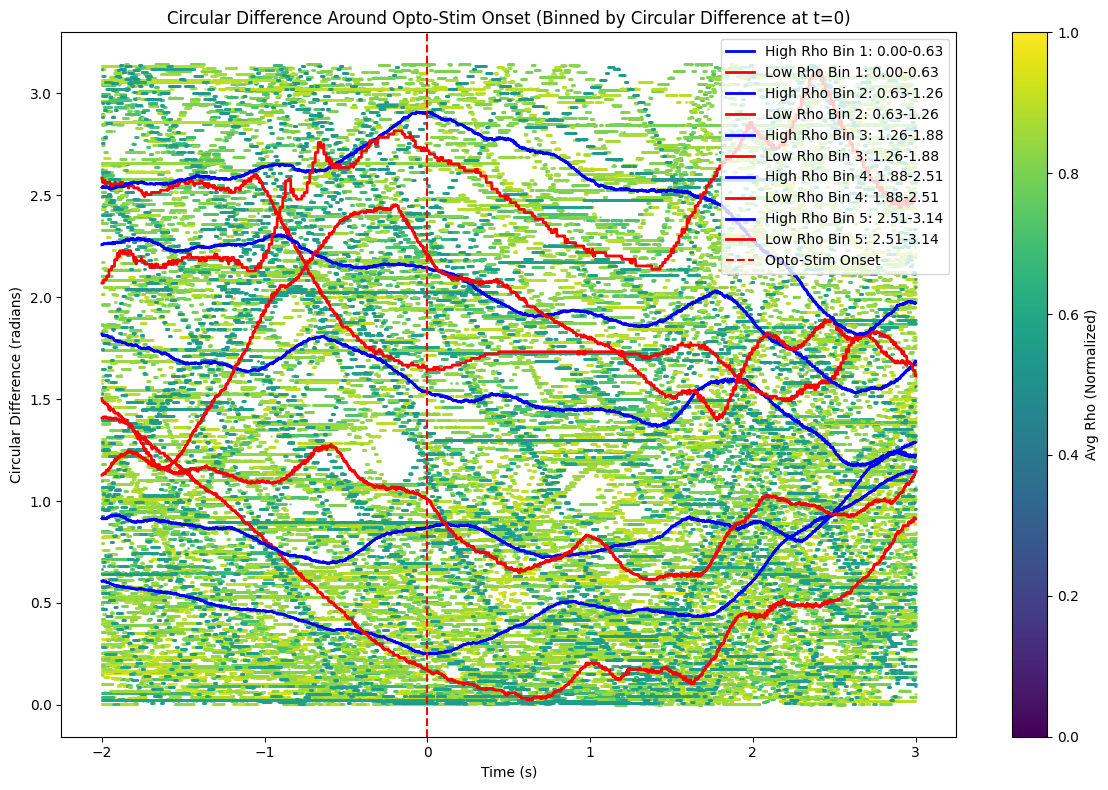

In [74]:
plot_opto_window_overlay_heading_1(combined_df_MBON09)

C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

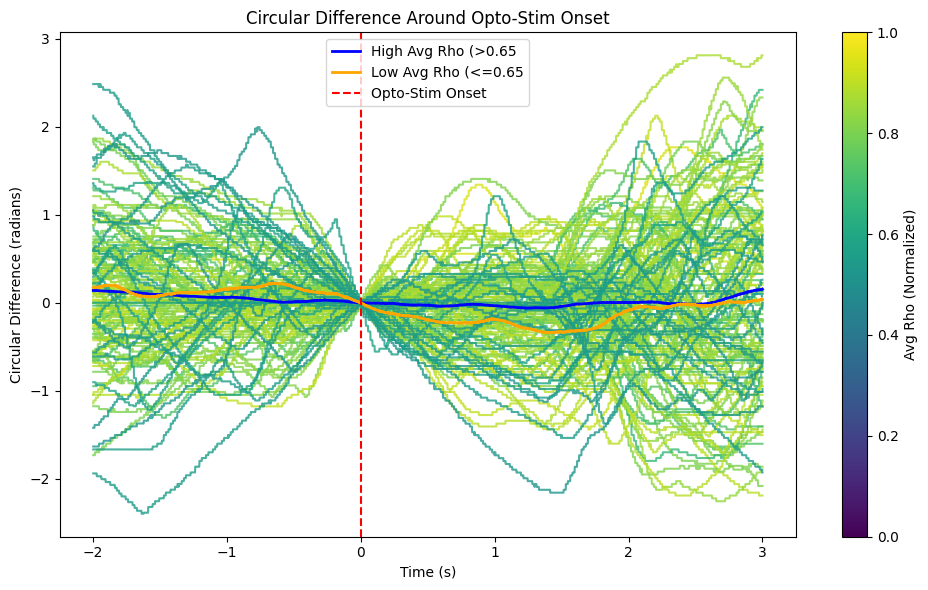

In [58]:
plot_opto_window_overlay_heading_3(combined_df_MBON09,rho_threshold=0.65)

C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

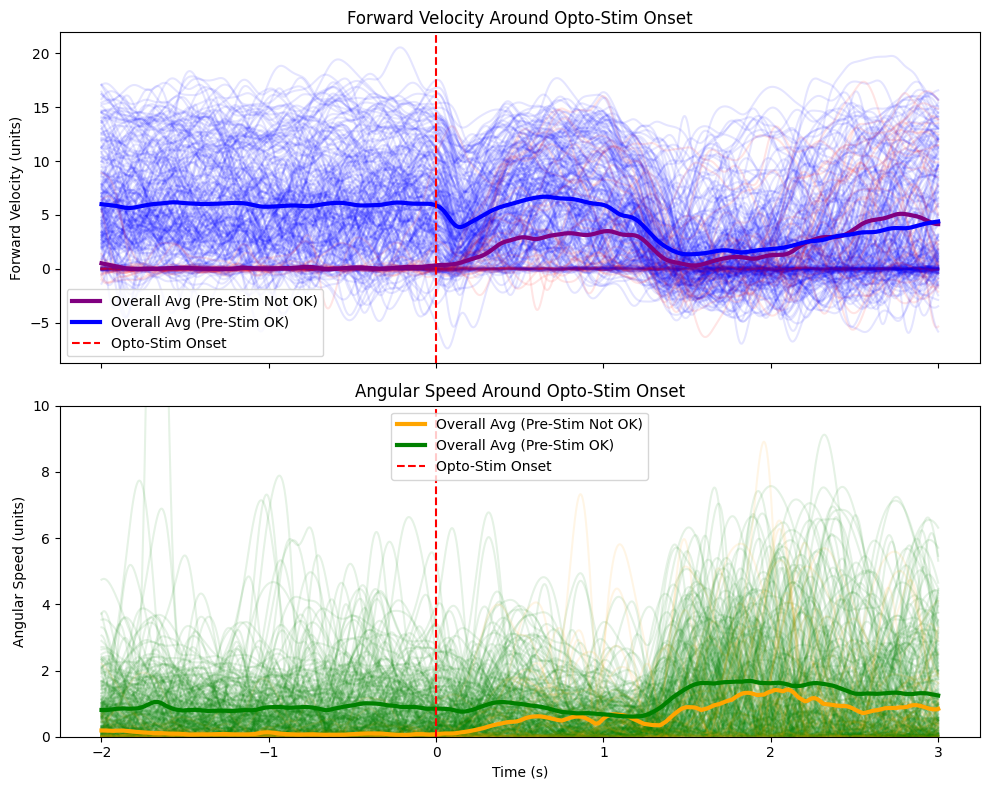

In [17]:
plot_opto_window_overlay_combined(combined_df_MBON09)

C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

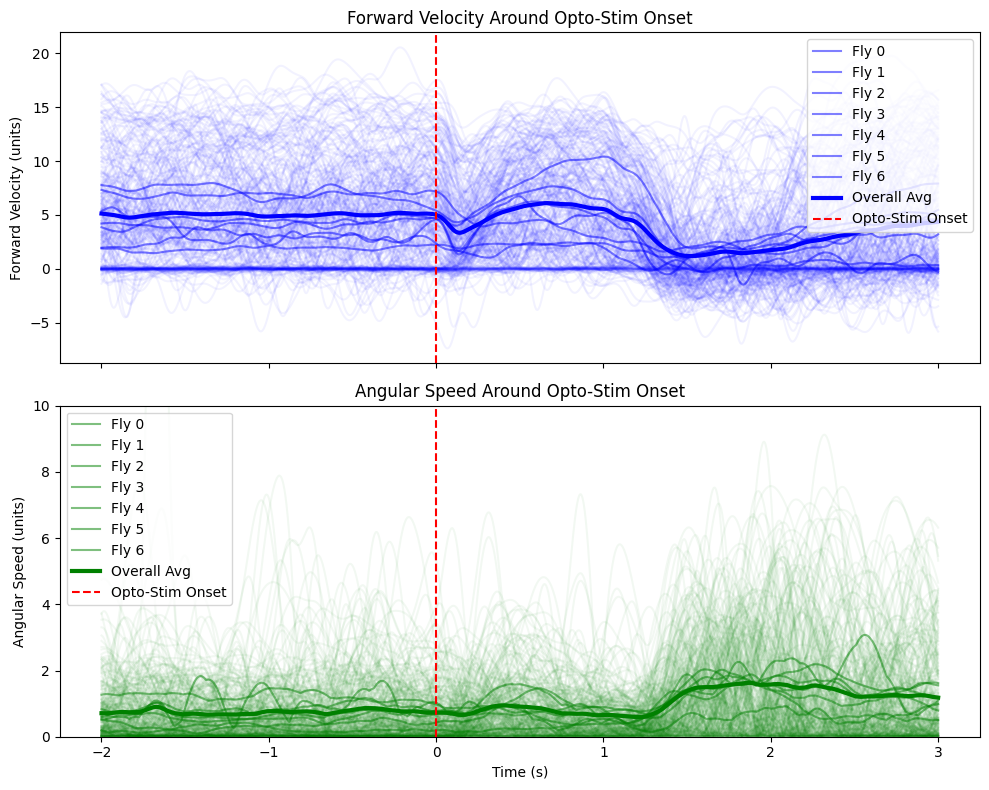

In [6]:
plot_opto_window_overlay_combined_flyavg(combined_df_MBON09)

In [36]:
folder_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control'
combined_df_ctrl = load_all_pro_mat_files_to_df(folder_path)

Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control\_2024_12_24_fly02_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control\_2024_12_24_fly04_session01_trial01A pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control\_2024_12_24_fly04_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control\_2024_12_24_fly04_session01_trial01C pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control\_2024_12_24_fly04_session01_trial01D pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/proce

C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3566847277.py:704: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3566847277.py:704: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3566847277.py:704: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

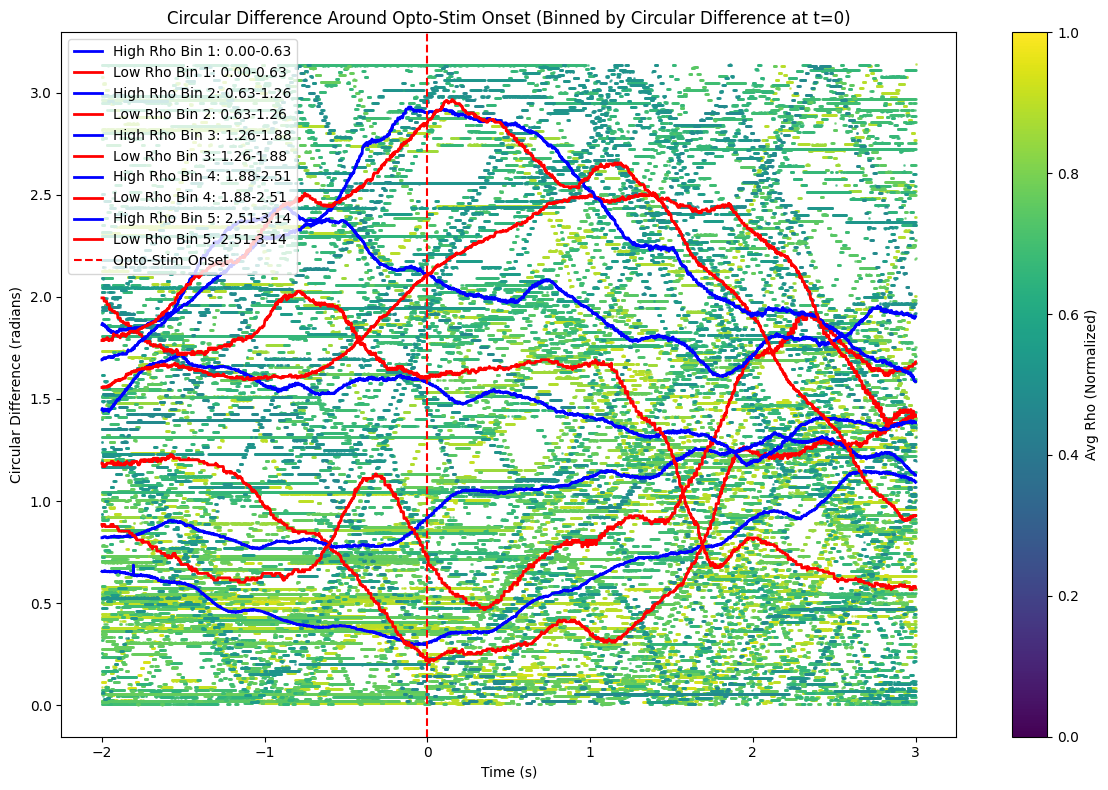

In [75]:
plot_opto_window_overlay_heading_1(combined_df_ctrl)

C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

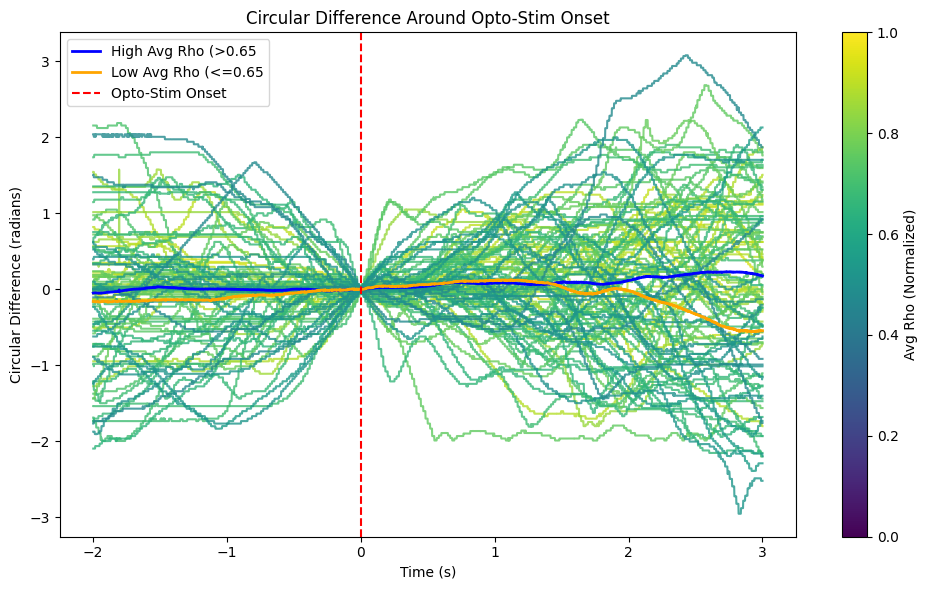

In [59]:
plot_opto_window_overlay_heading_3(combined_df_ctrl,rho_threshold=0.65)

C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

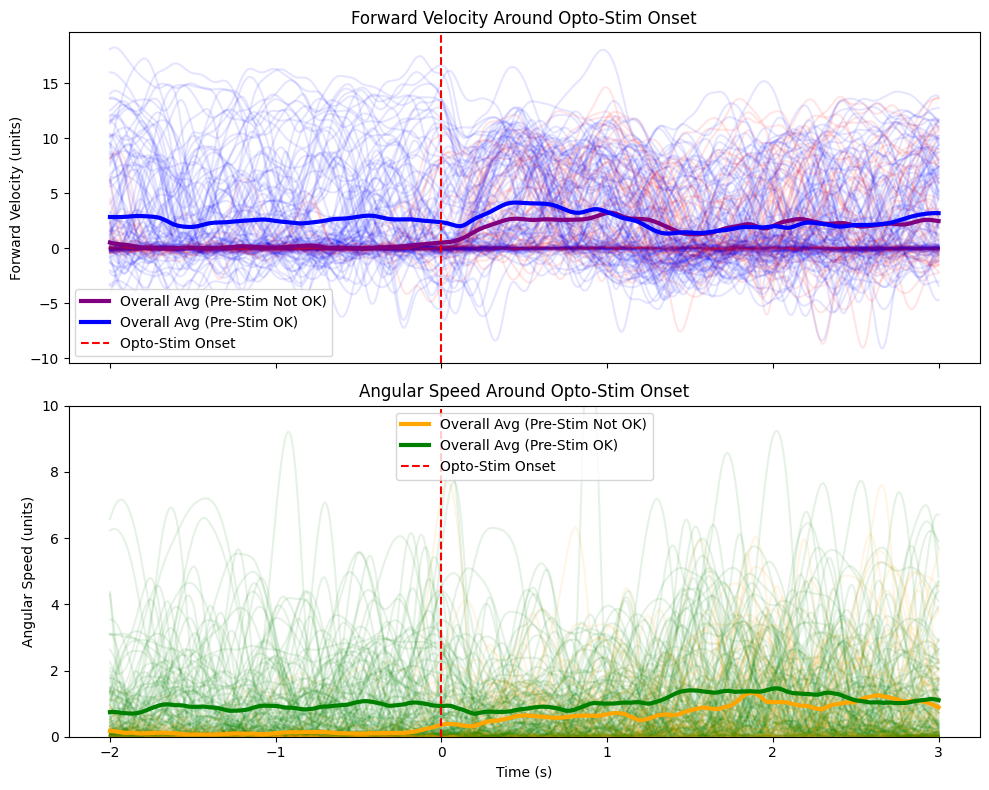

In [18]:
plot_opto_window_overlay_combined(combined_df_ctrl)

C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

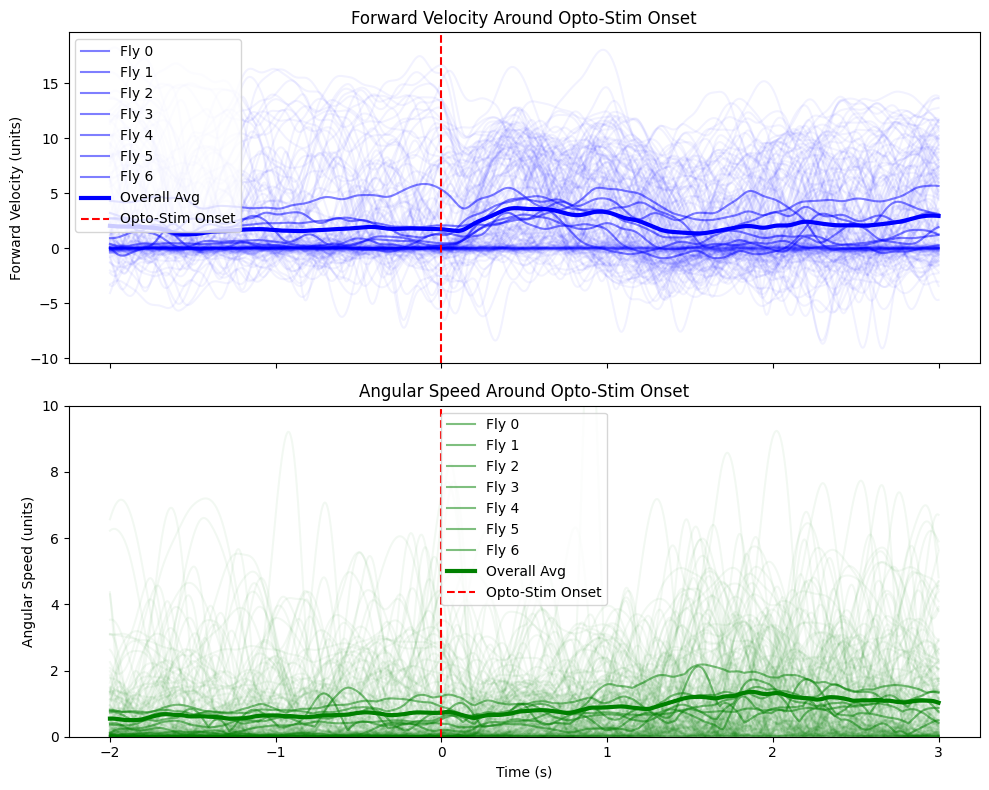

In [9]:
plot_opto_window_overlay_combined_flyavg(combined_df_ctrl)

In [ ]:
# heading changes around opto stim 
# divide walking vs stopping


### 0.5s stim pilot

In [13]:
folder_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/stim0.5s_pilot'
combined_df_MBON09_half = load_all_pro_mat_files_to_df(folder_path)

Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/stim0.5s_pilot\_2025_01_04_fly01_session01_trial01A pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/stim0.5s_pilot\_2025_01_04_fly01_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/stim0.5s_pilot\_2025_01_04_fly01_session01_trial01C pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/stim0.5s_pilot\_2025_01_04_fly01_session01_trial01D pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/stim0.5s_pilot\_2025_01_04_fly01_session01_trial02A pattern20 stim2 ftmode0_pro.mat
Loading fi

C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

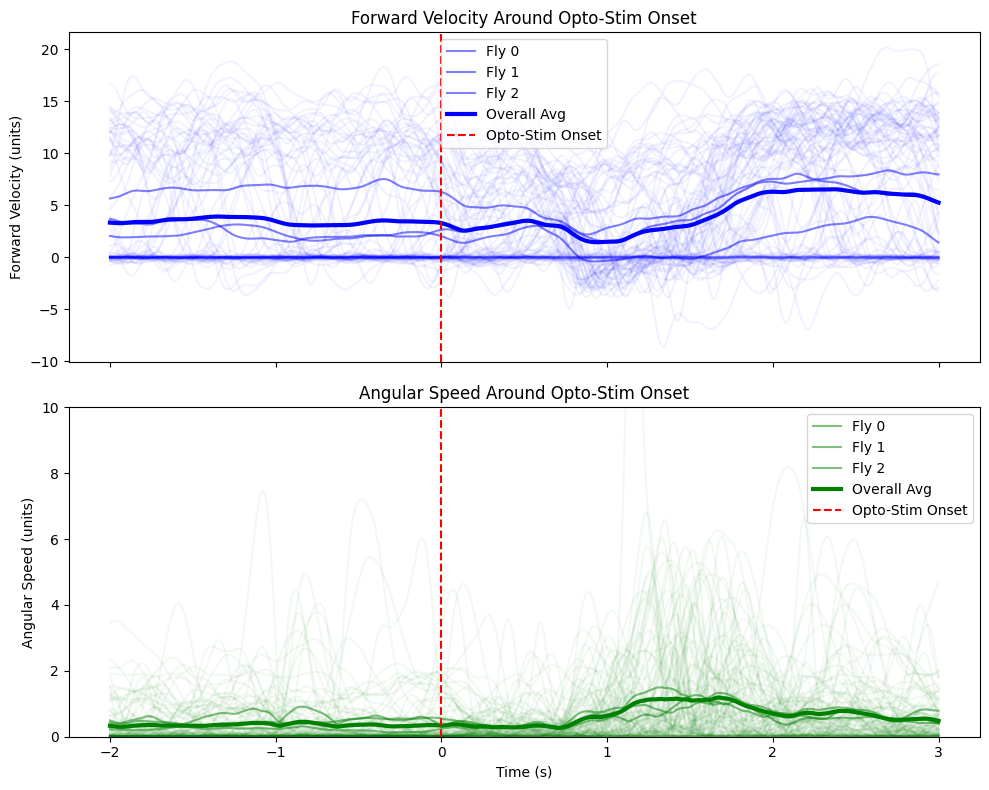

In [14]:
plot_opto_window_overlay_combined_flyavg(combined_df_MBON09_half)

C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

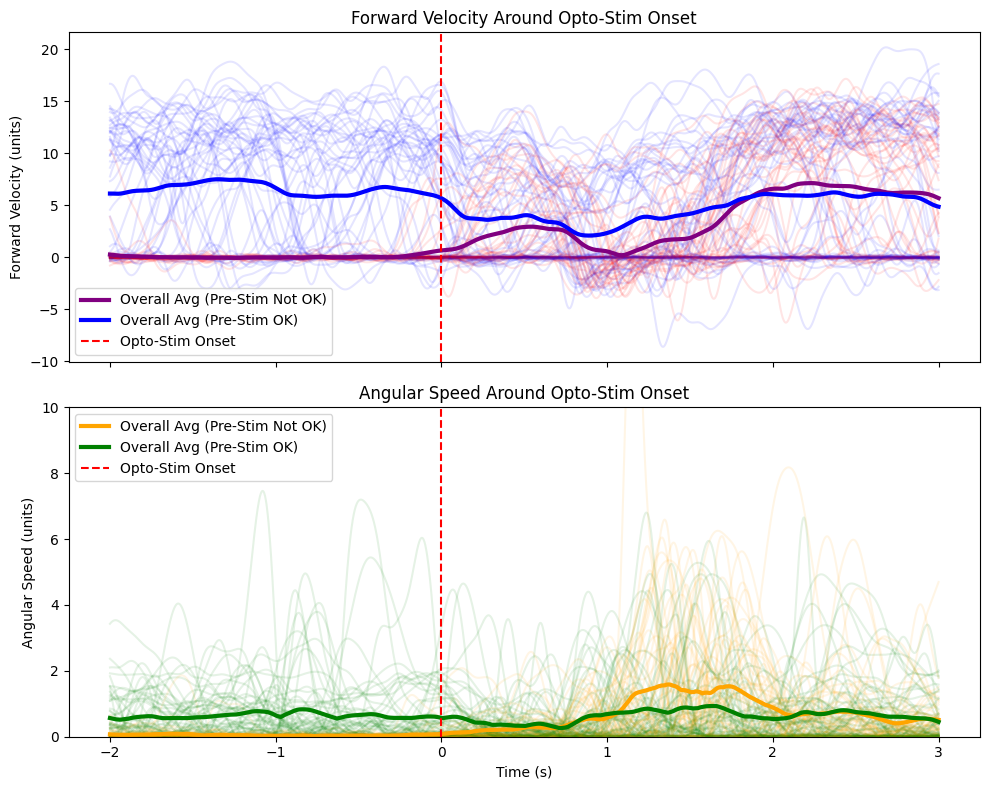

In [19]:
plot_opto_window_overlay_combined(combined_df_MBON09_half)

In [10]:
folder_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control/stim0.5s_pilot'
combined_df_ctrl_half = load_all_pro_mat_files_to_df(folder_path)

Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control/stim0.5s_pilot\_2025_01_03_fly10_session01_trial01A pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control/stim0.5s_pilot\_2025_01_03_fly10_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control/stim0.5s_pilot\_2025_01_03_fly10_session01_trial01C pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control/stim0.5s_pilot\_2025_01_03_fly10_session01_trial01D pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control/stim0.5s_pilot\_2025_01_03_fly15_session01_trial01A pattern20 stim2 ftmode0_pro.mat
Loadi

C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\1298873092.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

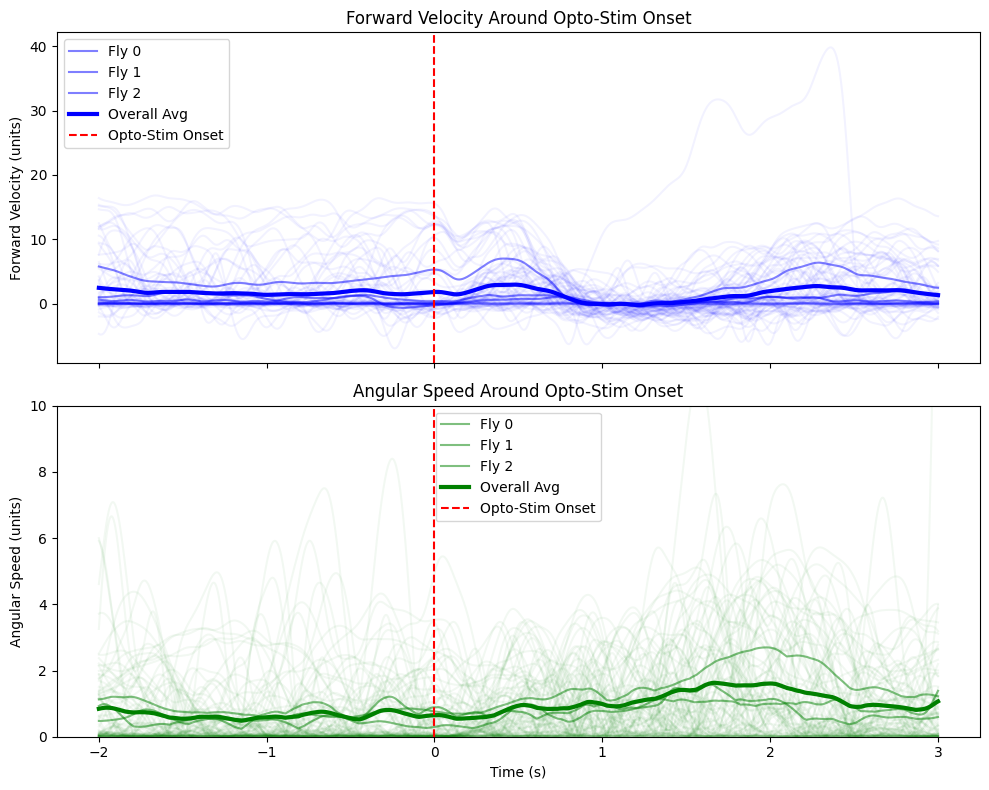

In [11]:
plot_opto_window_overlay_combined_flyavg(combined_df_ctrl_half)

C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_9924\3484803433.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

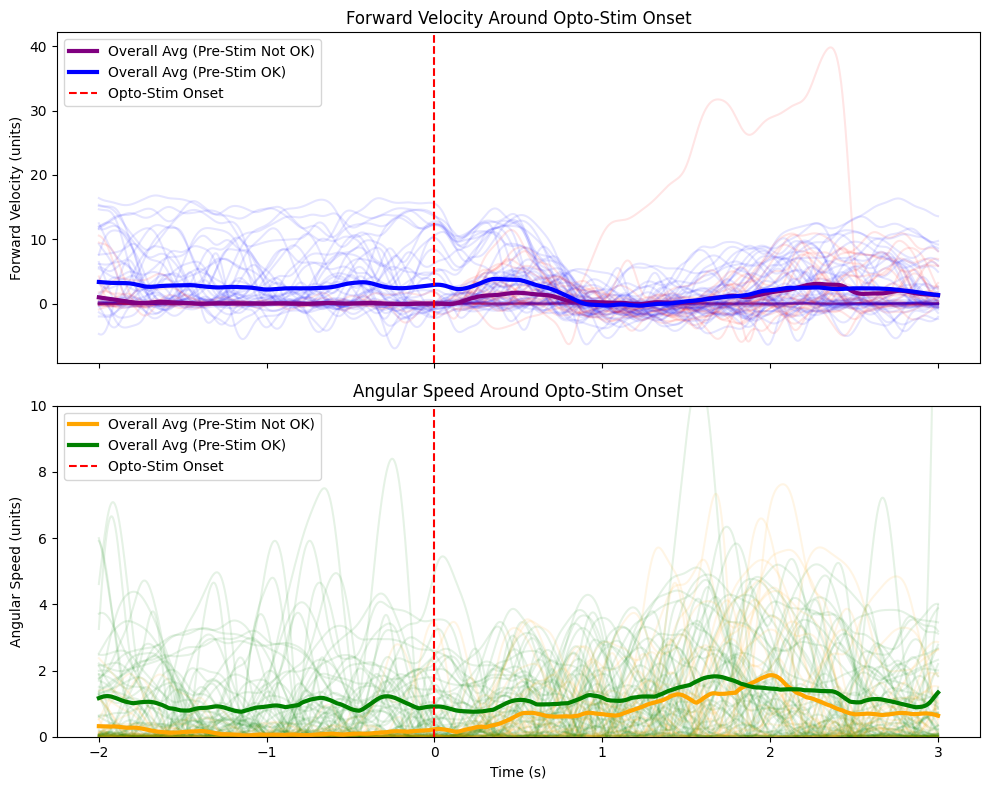

In [20]:
plot_opto_window_overlay_combined(combined_df_ctrl_half)